In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

2025-02-28 21:39:09.405427: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load dataset
file_path = 'only_3_sorted_stock_data_cleaned_nica.csv'

# data_all = 
data_with_close=pd.read_csv(file_path)
# data_all=data_with_close['close']

In [3]:
data_with_close

,Close,Qty,EPS
0,660.0,3547.0,17.94
1,651.0,5758.0,17.94
2,646.0,6085.0,17.94
3,648.0,6977.0,17.94
4,648.0,3303.0,17.94
...,...,...,...
1915,363.0,47627.0,2.04
1916,370.7,70533.0,2.04
1917,382.0,108899.0,2.04
1918,377.0,74518.0,2.04


In [4]:
data_all=data_with_close['Close']

In [5]:

# Train-Test Split
data_train = data_all[:int(len(data_all)*0.80)]
data_test = data_all[int(len(data_all)*0.80):]


In [6]:
data_train

0       660.0
1       651.0
2       646.0
3       648.0
4       648.0
        ...  
1531    739.0
1532    750.0
1533    775.0
1534    778.0
1535    778.0
Name: Close, Length: 1536, dtype: float64

In [7]:
data_train = pd.Series(data_train)
data_train=data_train.values.reshape(-1,1)

In [8]:
data_train

array([[660.],
       [651.],
       [646.],
       ...,
       [775.],
       [778.],
       [778.]])

In [9]:
# Normalize the dataset
scaler = MinMaxScaler()
data_train_scaled = scaler.fit_transform(data_train)

In [10]:
data_train_scaled

array([[0.46709677],
       [0.45548387],
       [0.44903226],
       ...,
       [0.61548387],
       [0.61935484],
       [0.61935484]])

In [11]:
# Convert data into sequences
def create_sequences(data, seq_length=50):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 50  # Lookback period
X_train, y_train = create_sequences(data_train_scaled, seq_length)

In [12]:
X_train.shape, y_train.shape

((1486, 50, 1), (1486, 1))

In [13]:
# Build LSTM model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(128, activation='tanh', return_sequences=True),
    Dropout(0.3),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Predicting all 8 features
])

In [14]:
# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
model.save("lstm_final.keras")

Epoch 1/50
47/47 [==============================] - 8s 77ms/step - loss: 0.0232
Epoch 2/50
47/47 [==============================] - 3s 68ms/step - loss: 0.0060
Epoch 3/50
47/47 [==============================] - 3s 65ms/step - loss: 0.0050
Epoch 4/50
47/47 [==============================] - 3s 66ms/step - loss: 0.0061
Epoch 5/50
47/47 [==============================] - 3s 67ms/step - loss: 0.0053
Epoch 6/50
47/47 [==============================] - 3s 64ms/step - loss: 0.0049
Epoch 7/50
47/47 [==============================] - 3s 67ms/step - loss: 0.0042
Epoch 8/50
47/47 [==============================] - 3s 68ms/step - loss: 0.0042
Epoch 9/50
47/47 [==============================] - 3s 65ms/step - loss: 0.0036
Epoch 10/50
47/47 [==============================] - 3s 65ms/step - loss: 0.0033
Epoch 11/50
47/47 [==============================] - 4s 75ms/step - loss: 0.0035
Epoch 12/50
47/47 [==============================] - 3s 71ms/step - loss: 0.0035
Epoch 13/50
47/47 [==================

In [17]:
data_test = pd.Series(data_test)
data_test=data_test.values.reshape(-1,1)

In [18]:
# Prepare Test Data
data_test_scaled=scaler.transform(data_test)
# Convert data into sequences
def create_sequences(data_test, seq_length=50):
    X, y = [], []
    for i in range(len(data_test) - seq_length):
        X.append(data_test[i:i+seq_length])
        y.append(data_test[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 50  # Lookback period
X_test, y_test = create_sequences(data_test_scaled, seq_length)


In [19]:
# Make Predictions
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
# y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))
y_test_actual = (scaler.inverse_transform(y_test.reshape(-1,1))).reshape(y_test.shape)

11/11 [==============================] - 1s 22ms/step


In [20]:
# Assuming 'Close' is the 0th feature and 'PE Ratio' is the 5th feature in the dataset
# Extract the actual test values
X_test_close = y_test_actual[:, 0]  # Actual Close values from test data
# X_test_pe = y_test_actual[:, 0]  # Actual PE Ratio values from test data
y_pred_close=y_pred[:,0]
# y_pred_pe=y_pred[:,2]


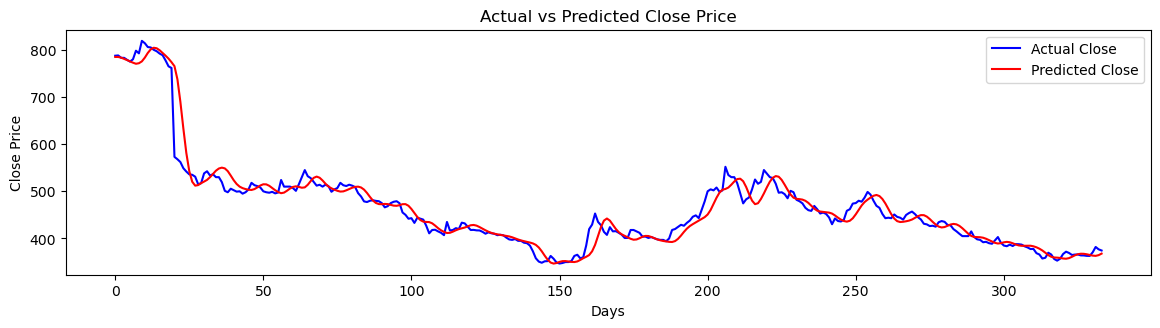

In [21]:
# Plot actual vs predicted values for Close and PE Ratio
plt.figure(figsize=(14, 7))

# Plot Close
plt.subplot(2, 1, 1)
plt.plot(X_test_close, label="Actual Close", color="blue")
plt.plot(y_pred_close, label="Predicted Close", color="red")
plt.xlabel("Days")
plt.ylabel("Close Price")
plt.title("Actual vs Predicted Close Price")
plt.legend()


In [ ]:
# # Plot PE Ratio
# plt.subplot(2, 1, 2)
# plt.plot(X_test_pe, label="Actual PE Ratio", color="green")
# plt.plot(y_pred_pe, label="Predicted PE Ratio",  color="red")
# plt.xlabel("Days")
# plt.ylabel("EPS Ratio")
# plt.title("Actual vs Predicted PE Ratio")
# plt.legend()

In [22]:
##For Future prediction
last_50_datas=data_all[-seq_length:]

In [23]:
last_50_datas

1870    415.2
1871    409.9
1872    405.0
1873    405.0
1874    405.0
1875    415.0
1876    403.0
1877    398.2
1878    397.0
1879    392.0
1880    392.9
1881    390.0
1882    388.8
1883    396.0
1884    403.0
1885    391.0
1886    385.0
1887    383.6
1888    386.9
1889    384.0
1890    388.0
1891    387.8
1892    387.0
1893    383.4
1894    381.0
1895    377.6
1896    377.8
1897    368.9
1898    366.0
1899    357.5
1900    359.0
1901    369.8
1902    366.0
1903    356.5
1904    353.0
1905    357.0
1906    367.0
1907    372.0
1908    369.3
1909    365.0
1910    365.9
1911    366.0
1912    364.1
1913    364.0
1914    363.1
1915    363.0
1916    370.7
1917    382.0
1918    377.0
1919    374.5
Name: Close, dtype: float64

In [25]:
last_50_datas = pd.Series(last_50_datas)
last_50_datas=last_50_datas.values.reshape(-1,1)

In [26]:
#Scale the data
last_50_datas_scaled=scaler.transform(last_50_datas)

In [27]:
#making predictions
def predict_next_n_days(model, data_scaled, n_days=100):
    predictions=[]
    input_sequence=data_scaled[-seq_length:].copy()

    for _ in range(n_days):
        input_data = np.expand_dims(input_sequence, axis=0)  # Reshape for model input
        next_day_features = model.predict(input_data, verbose=0)[0]  # Predict next day
        predictions.append(next_day_features)
        
        # Update input sequence: Remove first day, add predicted day
        next_day_input = np.append(input_sequence[1:], [next_day_features], axis=0)
        input_sequence = next_day_input
        
    return np.array(predictions)

In [45]:
# Example usage
# last_100_days = scaler.transform(last_100_days_raw)  # Normalize input if needed
predicted_features = predict_next_n_days(model, last_50_datas_scaled, n_days=30)

In [46]:
predicted_features

array([[0.09474981],
       [0.09775984],
       [0.09870961],
       [0.09815948],
       [0.09693678],
       [0.09560909],
       [0.09437387],
       [0.09319378],
       [0.09196811],
       [0.09063662],
       [0.08920011],
       [0.08769559],
       [0.08616644],
       [0.08464475],
       [0.08314876],
       [0.08168799],
       [0.08026901],
       [0.078897  ],
       [0.07757749],
       [0.07631509],
       [0.07511322],
       [0.07397296],
       [0.07289384],
       [0.07187392],
       [0.07091025],
       [0.06999891],
       [0.06913571],
       [0.06831567],
       [0.06753407],
       [0.0667854 ]], dtype=float32)

In [47]:
predicted_features_inverse = scaler.inverse_transform(predicted_features)

In [48]:
predicted_features_inverse

array([[371.4311 ],
       [373.7639 ],
       [374.49994],
       [374.0736 ],
       [373.126  ],
       [372.09705],
       [371.13974],
       [370.2252 ],
       [369.2753 ],
       [368.24338],
       [367.13007],
       [365.96408],
       [364.779  ],
       [363.59967],
       [362.4403 ],
       [361.3082 ],
       [360.20847],
       [359.14517],
       [358.12256],
       [357.1442 ],
       [356.21274],
       [355.32904],
       [354.49274],
       [353.7023 ],
       [352.95544],
       [352.24915],
       [351.58017],
       [350.94464],
       [350.3389 ],
       [349.75867]], dtype=float32)

In [49]:
predicted_features_inverse[0]

array([371.4311], dtype=float32)

In [50]:
# predicted_features_inverse[0][0]

In [51]:
x_future_close=predicted_features_inverse[:, 0]


In [52]:
x_future_close

array([371.4311 , 373.7639 , 374.49994, 374.0736 , 373.126  , 372.09705,
       371.13974, 370.2252 , 369.2753 , 368.24338, 367.13007, 365.96408,
       364.779  , 363.59967, 362.4403 , 361.3082 , 360.20847, 359.14517,
       358.12256, 357.1442 , 356.21274, 355.32904, 354.49274, 353.7023 ,
       352.95544, 352.24915, 351.58017, 350.94464, 350.3389 , 349.75867],
      dtype=float32)

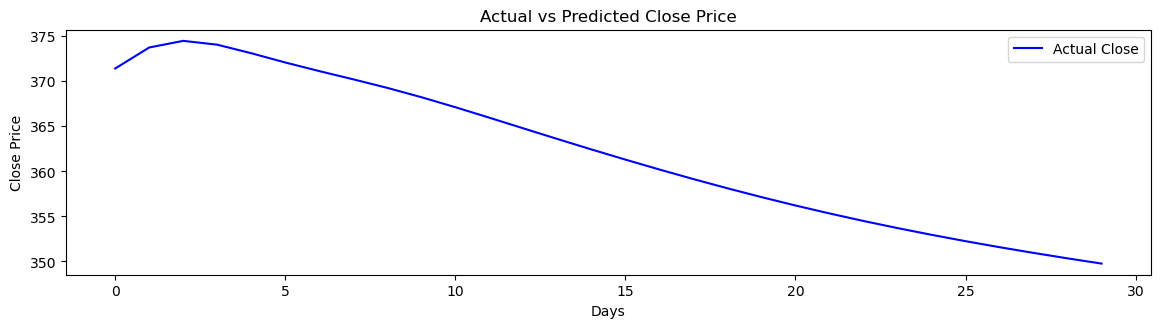

In [53]:
# Plot actual vs predicted values for Close and PE Ratio
plt.figure(figsize=(14, 7))

# Plot Close
plt.subplot(2, 1, 1)
plt.plot(x_future_close, label="Actual Close", color="blue")
# plt.plot(y_pred_close, label="Predicted Close", color="red")
plt.xlabel("Days")
plt.ylabel("Close Price")
plt.title("Actual vs Predicted Close Price")
plt.savefig('future_predict')
plt.legend()


In [ ]:
predicted_data=predicted_features_inverse

In [ ]:
predicted_features_inverse.shape

In [ ]:
# predicted_data.t
df=pd.DataFrame(predicted_data)
df.to_csv("prediction.csv", index=False)